# 1. Data Exploration

In [4]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_excel('PSP_Jan_Feb_2019.xlsx')

# Display basic information about the dataset
print(df.info())
print(df.describe())

# Display first few rows of the dataset
print(df.head())

# Check the unique values for each column to understand the data types and categories
print(df['country'].unique())
print(df['PSP'].unique())
print(df['card'].unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50410 entries, 0 to 50409
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Unnamed: 0  50410 non-null  int64         
 1   tmsp        50410 non-null  datetime64[ns]
 2   country     50410 non-null  object        
 3   amount      50410 non-null  int64         
 4   success     50410 non-null  int64         
 5   PSP         50410 non-null  object        
 6   3D_secured  50410 non-null  int64         
 7   card        50410 non-null  object        
dtypes: datetime64[ns](1), int64(4), object(3)
memory usage: 3.1+ MB
None
         Unnamed: 0        amount       success    3D_secured
count  50410.000000  50410.000000  50410.000000  50410.000000
mean   25204.500000    202.395715      0.202896      0.238266
std    14552.257872     96.274730      0.402160      0.426027
min        0.000000      6.000000      0.000000      0.000000
25%    12602.250000    133.0

# 2.2 Data Understanding

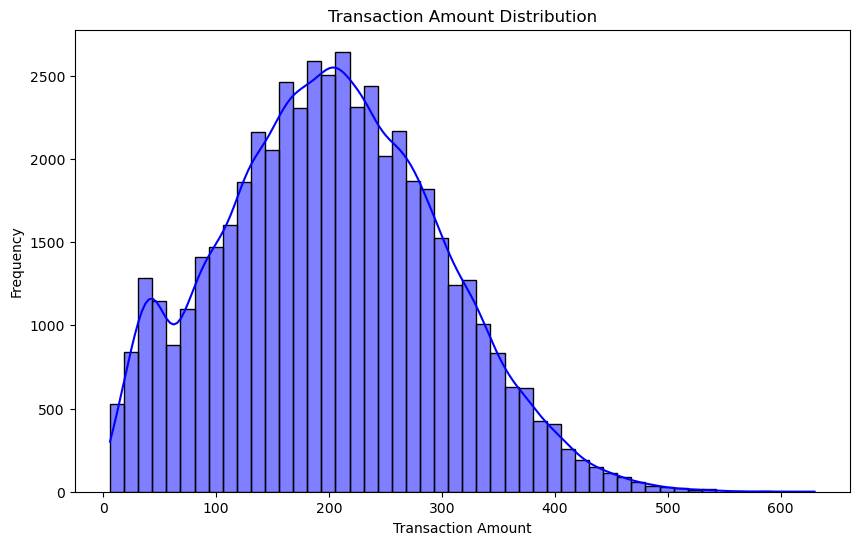

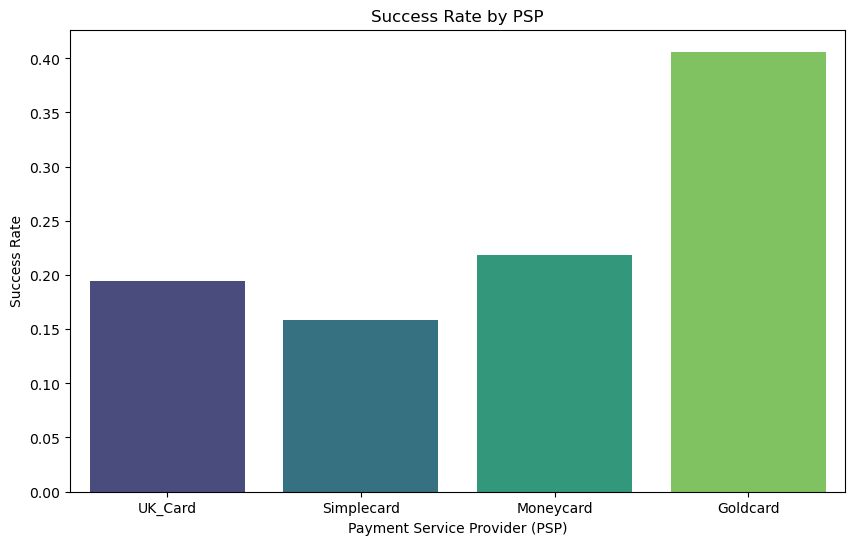

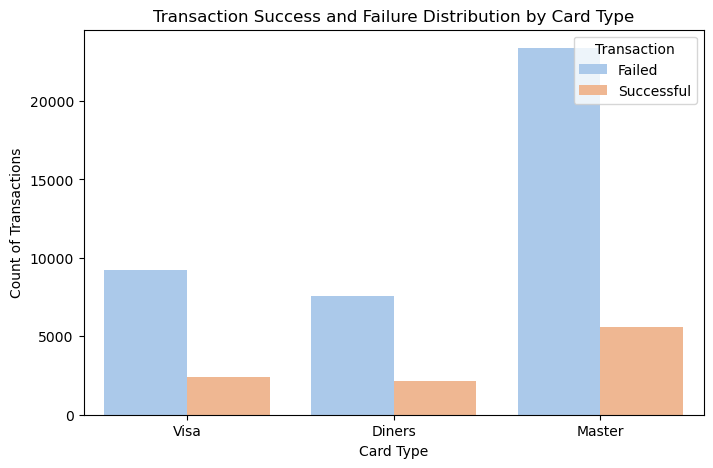

In [5]:
# Plot the distribution of transaction amounts
plt.figure(figsize=(10, 6))
sns.histplot(df['amount'], bins=50, kde=True, color='blue')
plt.title('Transaction Amount Distribution')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.show()

# Success rates by PSP
plt.figure(figsize=(10, 6))
sns.barplot(x='PSP', y='success', data=df, estimator=lambda x: sum(x)/len(x), ci=None, palette='viridis')
plt.title('Success Rate by PSP')
plt.xlabel('Payment Service Provider (PSP)')
plt.ylabel('Success Rate')
plt.show()

# Distribution of transactions by card type
plt.figure(figsize=(8, 5))
sns.countplot(x='card', hue='success', data=df, palette='pastel')
plt.title('Transaction Success and Failure Distribution by Card Type')
plt.xlabel('Card Type')
plt.ylabel('Count of Transactions')
plt.legend(title='Transaction', loc='upper right', labels=['Failed', 'Successful'])
plt.show()


# 2.3 Data Preparation

In [20]:
import numpy as np
print("Initial dataset information:")
print(df.info())
print(df.describe())

# Handle missing values: Drop rows with missing values 
df.dropna(inplace=True)
# Remove duplicates
df.drop_duplicates(inplace=True)

# Check for erroneous timestamps and correct/remove them
df['tmsp'] = pd.to_datetime(df['tmsp'], errors='coerce')  # Convert to datetime, coerce errors to NaT
df = df.dropna(subset=['tmsp'])  # Remove rows where timestamp conversion failed

# Detect and handle outliers in the 'amount' column:Using the Interquartile Range (IQR) method
Q1 = df['amount'].quantile(0.25)
Q3 = df['amount'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
df = df[(df['amount'] >= lower_bound) & (df['amount'] <= upper_bound)]

print("Cleaned dataset information:")
print(df.info())
print(df.describe())

Initial dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50410 entries, 0 to 50409
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Unnamed: 0  50410 non-null  int64         
 1   tmsp        50410 non-null  datetime64[ns]
 2   country     50410 non-null  object        
 3   amount      50410 non-null  int64         
 4   success     50410 non-null  int64         
 5   PSP         50410 non-null  object        
 6   3D_secured  50410 non-null  int64         
 7   card        50410 non-null  object        
dtypes: datetime64[ns](1), int64(4), object(3)
memory usage: 3.1+ MB
None
         Unnamed: 0        amount       success    3D_secured
count  50410.000000  50410.000000  50410.000000  50410.000000
mean   25204.500000    202.395715      0.202896      0.238266
std    14552.257872     96.274730      0.402160      0.426027
min        0.000000      6.000000      0.000000      0.000000

# 2. Hyperparameter Tuning: Grid Search for Random Forest

In [7]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
# Check the column names in the DataFrame
print("Column names in the DataFrame:")
print(df.columns)
# Perform initial data preparation steps if not done already
# Convert 'tmsp' to datetime format
df['tmsp'] = pd.to_datetime(df['tmsp'], errors='coerce')
# Remove rows with NaT in 'tmsp'
df = df.dropna(subset=['tmsp'])

# Feature Engineering: Retry Identification
df = df.sort_values(by='tmsp')
df['is_retry'] = (df['amount'].shift() == df['amount']) & \
                 (df['country'].shift() == df['country']) & \
                 ((df['tmsp'] - df['tmsp'].shift()).dt.seconds <= 60)
# Time-based features
df['hour'] = df['tmsp'].dt.hour
df['day_of_week'] = df['tmsp'].dt.dayofweek
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
# Aggregated success rate per PSP
psp_success_rate = df.groupby('PSP')['success'].mean().to_dict()
df['psp_success_rate'] = df['PSP'].map(psp_success_rate)

# Encode categorical features: 'country', 'card', 'PSP'
label_encoders = {}
for column in ['country', 'card', 'PSP']:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le  # Store encoder for possible inverse_transform later
# Double-check the DataFrame columns after preprocessing
print("DataFrame columns after preprocessing:")
print(df.columns)
# Ensure all necessary columns are present in the DataFrame
required_columns = ['amount', '3D_secured', 'is_retry', 'hour', 'day_of_week', 'psp_success_rate', 'country', 'card', 'PSP']
missing_columns = [col for col in required_columns if col not in df.columns]
if missing_columns:
    print(f"Missing columns: {missing_columns}")
else:
    print("All required columns are present.")

Column names in the DataFrame:
Index(['Unnamed: 0', 'tmsp', 'country', 'amount', 'success', 'PSP',
       '3D_secured', 'card'],
      dtype='object')
DataFrame columns after preprocessing:
Index(['Unnamed: 0', 'tmsp', 'country', 'amount', 'success', 'PSP',
       '3D_secured', 'card', 'is_retry', 'hour', 'day_of_week', 'is_weekend',
       'psp_success_rate'],
      dtype='object')
All required columns are present.


In [8]:
# Define features and target variable
X = df[required_columns]
y = df['success']
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Feature scaling for Logistic Regression: Only scale numeric columns (amount, psp_success_rate, hour, day_of_week)
scaler = StandardScaler()
X_train[['amount', 'psp_success_rate', 'hour', 'day_of_week']] = scaler.fit_transform(X_train[['amount', 'psp_success_rate', 'hour', 'day_of_week']])
X_test[['amount', 'psp_success_rate', 'hour', 'day_of_week']] = scaler.transform(X_test[['amount', 'psp_success_rate', 'hour', 'day_of_week']])
# Baseline Model: Logistic Regression
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)
# Evaluate the Logistic Regression model
y_pred_log_reg = log_reg.predict(X_test)
print("Logistic Regression Model Performance:")
print(classification_report(y_test, y_pred_log_reg))
print(confusion_matrix(y_test, y_pred_log_reg))

Logistic Regression Model Performance:
              precision    recall  f1-score   support

           0       0.81      1.00      0.90      8163
           1       0.58      0.02      0.05      1919

    accuracy                           0.81     10082
   macro avg       0.70      0.51      0.47     10082
weighted avg       0.77      0.81      0.73     10082

[[8129   34]
 [1872   47]]


In [9]:
# Advanced Model: Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate the Random Forest model
y_pred_rf = rf_model.predict(X_test)
print("Random Forest Model Performance:")
print(classification_report(y_test, y_pred_rf))
print(confusion_matrix(y_test, y_pred_rf))

Random Forest Model Performance:
              precision    recall  f1-score   support

           0       0.82      0.93      0.87      8163
           1       0.32      0.14      0.20      1919

    accuracy                           0.78     10082
   macro avg       0.57      0.54      0.53     10082
weighted avg       0.73      0.78      0.74     10082

[[7574  589]
 [1644  275]]


In [10]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best hyperparameters from Grid Search
print(f"Best Parameters from Grid Search: {grid_search.best_params_}")

# Best model from Grid Search
best_rf_model = grid_search.best_estimator_

# Evaluate the best Random Forest model
y_pred_best_rf = best_rf_model.predict(X_test)
print("Best Random Forest Model Performance after Grid Search:")
print(classification_report(y_test, y_pred_best_rf))
print(confusion_matrix(y_test, y_pred_best_rf))

Fitting 3 folds for each of 324 candidates, totalling 972 fits
Best Parameters from Grid Search: {'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Best Random Forest Model Performance after Grid Search:
              precision    recall  f1-score   support

           0       0.82      0.99      0.90      8163
           1       0.65      0.06      0.11      1919

    accuracy                           0.81     10082
   macro avg       0.73      0.53      0.50     10082
weighted avg       0.79      0.81      0.75     10082

[[8102   61]
 [1807  112]]


# Rough

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50410 entries, 0 to 50409
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Unnamed: 0  50410 non-null  int64         
 1   tmsp        50410 non-null  datetime64[ns]
 2   country     50410 non-null  object        
 3   amount      50410 non-null  int64         
 4   success     50410 non-null  int64         
 5   PSP         50410 non-null  object        
 6   3D_secured  50410 non-null  int64         
 7   card        50410 non-null  object        
dtypes: datetime64[ns](1), int64(4), object(3)
memory usage: 3.1+ MB
None
         Unnamed: 0        amount       success    3D_secured
count  50410.000000  50410.000000  50410.000000  50410.000000
mean   25204.500000    202.395715      0.202896      0.238266
std    14552.257872     96.274730      0.402160      0.426027
min        0.000000      6.000000      0.000000      0.000000
25%    12602.250000    133.0

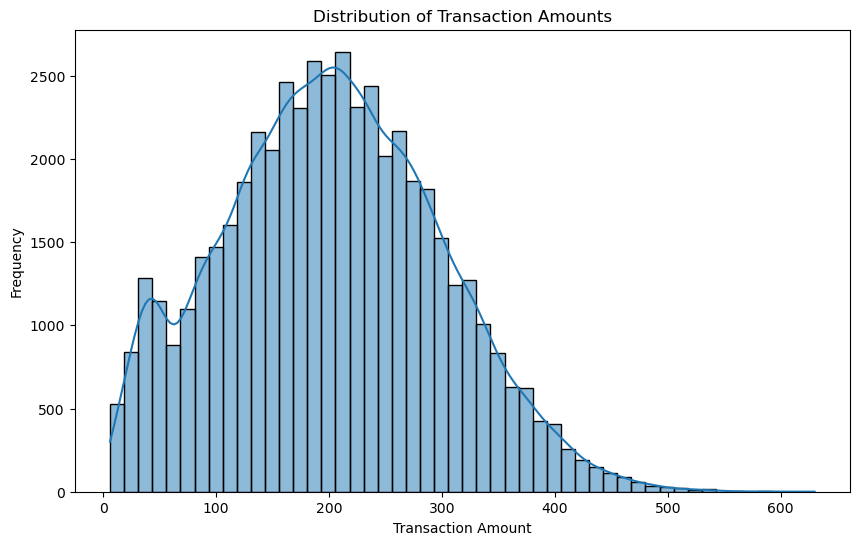

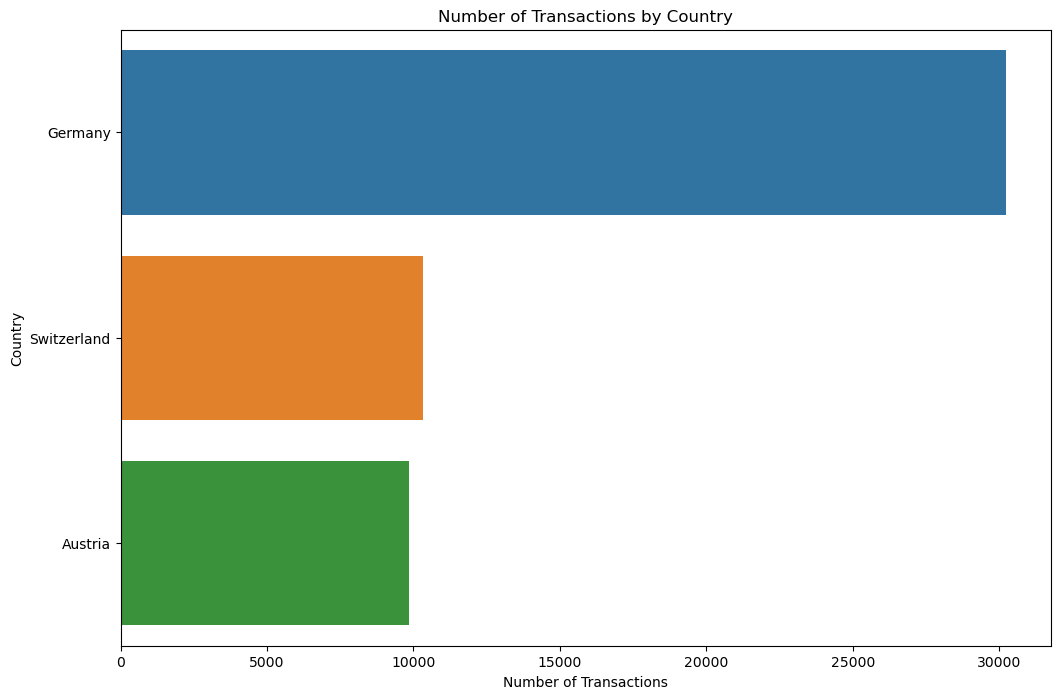

          PSP   success
0    Goldcard  0.406172
1   Moneycard  0.218754
2  Simplecard  0.158123
3     UK_Card  0.194338


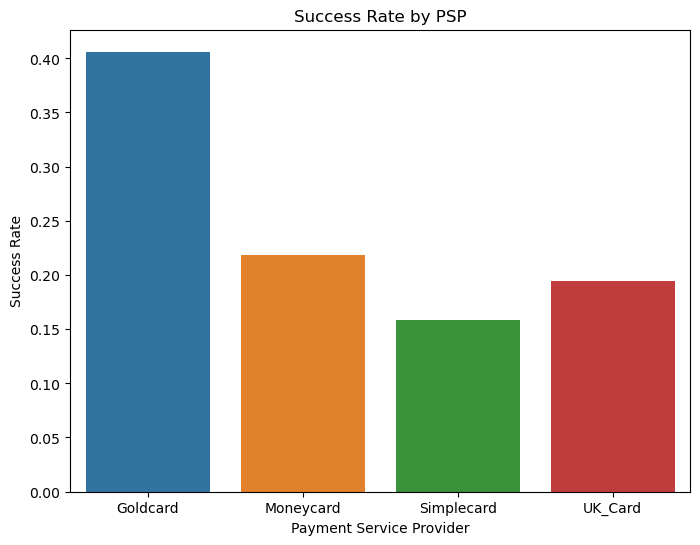

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
data = pd.read_excel('PSP_Jan_Feb_2019.xlsx')

# Basic data information
print(data.info())
print(data.describe())

# Check for missing values
print(data.isnull().sum())

# Visualize the distribution of the 'amount' feature
plt.figure(figsize=(10, 6))
sns.histplot(data['amount'], bins=50, kde=True)
plt.title('Distribution of Transaction Amounts')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.show()

# Check the distribution of transactions by country
plt.figure(figsize=(12, 8))
sns.countplot(y='country', data=data, order=data['country'].value_counts().index)
plt.title('Number of Transactions by Country')
plt.xlabel('Number of Transactions')
plt.ylabel('Country')
plt.show()

# Check the success rate by PSP
success_rate_by_psp = data.groupby('PSP')['success'].mean().reset_index()
print(success_rate_by_psp)

# Visualize the success rate by PSP
plt.figure(figsize=(8, 6))
sns.barplot(x='PSP', y='success', data=success_rate_by_psp)
plt.title('Success Rate by PSP')
plt.xlabel('Payment Service Provider')
plt.ylabel('Success Rate')
plt.show()


In [23]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np

# Convert 'tmsp' to datetime
data['tmsp'] = pd.to_datetime(data['tmsp'])

# Feature Engineering: Identify repeated attempts
data = data.sort_values(by=['country', 'amount', 'tmsp'])
data['time_diff'] = data.groupby(['country', 'amount'])['tmsp'].diff().dt.total_seconds()
data['is_retry'] = data['time_diff'].apply(lambda x: 1 if x <= 60 else 0).fillna(0)

# Encode categorical features
le_card = LabelEncoder()
data['card_encoded'] = le_card.fit_transform(data['card'])

le_psp = LabelEncoder()
data['psp_encoded'] = le_psp.fit_transform(data['PSP'])

le_country = LabelEncoder()
data['country_encoded'] = le_country.fit_transform(data['country'])

# Select relevant features
features = ['amount', '3D_secured', 'card_encoded', 'country_encoded', 'psp_encoded', 'is_retry']
X = data[features]
y = data['success']

# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [24]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Baseline Model: Logistic Regression
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

# Evaluate the baseline model
print('Baseline Model - Logistic Regression:')
print('Accuracy:', accuracy_score(y_test, y_pred_lr))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred_lr))
print('Classification Report:\n', classification_report(y_test, y_pred_lr))

# Predictive Model: Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Evaluate the predictive model
print('Predictive Model - Random Forest:')
print('Accuracy:', accuracy_score(y_test, y_pred_rf))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred_rf))
print('Classification Report:\n', classification_report(y_test, y_pred_rf))


Baseline Model - Logistic Regression:
Accuracy: 0.7974608212656219
Confusion Matrix:
 [[8040    0]
 [2042    0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.80      1.00      0.89      8040
           1       0.00      0.00      0.00      2042

    accuracy                           0.80     10082
   macro avg       0.40      0.50      0.44     10082
weighted avg       0.64      0.80      0.71     10082



C:\Users\angel\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\angel\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\angel\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Predictive Model - Random Forest:
Accuracy: 0.734378099583416
Confusion Matrix:
 [[7054  986]
 [1692  350]]
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.88      0.84      8040
           1       0.26      0.17      0.21      2042

    accuracy                           0.73     10082
   macro avg       0.53      0.52      0.52     10082
weighted avg       0.70      0.73      0.71     10082



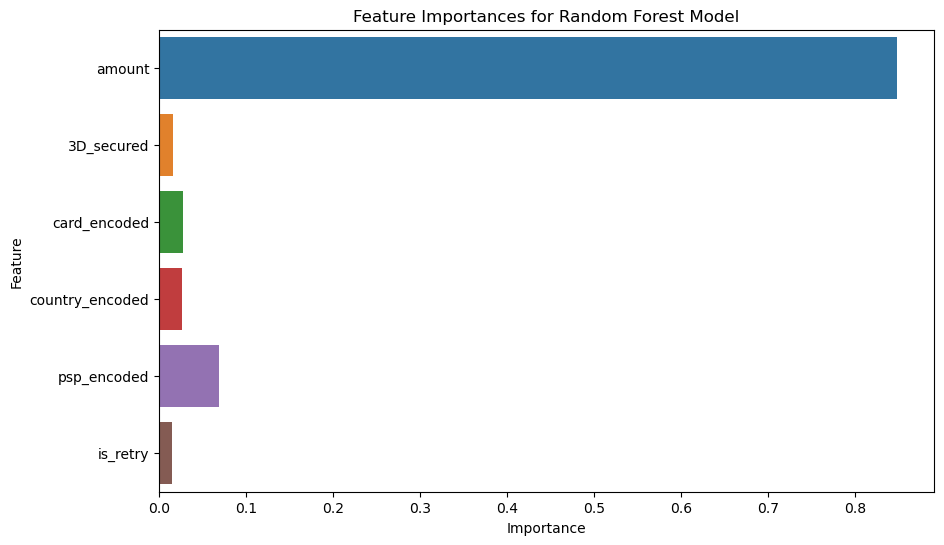

Error Analysis: Misclassified Transactions


AttributeError: 'numpy.ndarray' object has no attribute 'head'

In [25]:
# Feature Importance for Random Forest
importances = rf_model.feature_importances_
feature_names = features

# Plot Feature Importances
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=feature_names)
plt.title('Feature Importances for Random Forest Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Error Analysis
errors = X_test[y_test != y_pred_rf]
print("Error Analysis: Misclassified Transactions")
print(errors.head())


In [26]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')

# Fit the model to the training data
grid_search.fit(X_train, y_train)

# Best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Best estimator
best_rf_model = grid_search.best_estimator_

# Predict using the tuned model
y_pred_best_rf = best_rf_model.predict(X_test)

# Evaluate the tuned model
print('Tuned Model - Random Forest:')
print('Accuracy:', accuracy_score(y_test, y_pred_best_rf))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred_best_rf))
print('Classification Report:\n', classification_report(y_test, y_pred_best_rf))


Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Tuned Model - Random Forest:
Accuracy: 0.7993453679825432
Confusion Matrix:
 [[7988   52]
 [1971   71]]
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.99      0.89      8040
           1       0.58      0.03      0.07      2042

    accuracy                           0.80     10082
   macro avg       0.69      0.51      0.48     10082
weighted avg       0.76      0.80      0.72     10082

